# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [77]:
# initial imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import panel as pn
import plotly.express as px
from pathlib import Path
from dotenv import load_dotenv

# Initialize the Panel Extensions (for Plotly)
pn.extension('plotly')

In [78]:
# Read the Mapbox API key
load_dotenv()
mapbox_token = os.getenv("MAPBOX")
px.set_mapbox_access_token(mapbox_token)

# Import Data

In [79]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(file_path)
df_neighborhood_locations.rename(columns={'Neighborhood': 'neighborhood'}, inplace=True)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [80]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year.(bar)"""
    mean_units_per_year = sfo_data['housing_units'].groupby(sfo_data.index).mean()
    fig_housing_units = plt.figure()
    plot_housing_units = mean_units_per_year.plot.bar(ylim=(370000,387500))
    plot_housing_units.set_xlabel("Year", fontsize=12)
    plot_housing_units.set_ylabel("Housing Units", fontsize=12)
    plot_housing_units.set_title("Average Housing Units Per Year", fontsize=14, fontweight="bold")
    plt.close(fig_housing_units)
    return pn.pane.Matplotlib(fig_housing_units, tight=True)

def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year.(line)"""
    avg_gross = sfo_data.groupby('year')['sale_price_sqr_foot', 'gross_rent'].mean()
    fig_avg_gross = plt.figure()
    plot_avg_gross = avg_gross['gross_rent'].plot()
    plot_avg_gross.set_title("Average Gross Rent in San Francisco", fontsize=12, fontweight="bold")
    plot_avg_gross.set_ylabel('Gross Rent', fontsize=12)
    plt.close(fig_avg_gross)
    return pn.pane.Matplotlib(fig_avg_gross)


def average_sales_price():
    """Average Sales Price Per Year.(line)"""
    avg_gross = sfo_data.groupby('year')['sale_price_sqr_foot', 'gross_rent'].mean()
    avg_sale = avg_gross['sale_price_sqr_foot']
    fig_avg_sale = plt.figure()
    plot_avg_sale = avg_sale.plot()
    plot_avg_sale.set_title("Average Sale Price Per Square Foot in San Francisco", fontsize=12, fontweight="bold")
    plot_avg_sale.set_ylabel('Avg. Sale Price', fontsize=12)
    plt.close(fig_avg_sale)
    return pn.pane.Matplotlib(fig_avg_sale)


def average_price_by_neighborhood():
    """Average Prices by Neighborhood.(line/widget)""" 
    neighborhood = sfo_data.groupby(['year','neighborhood'])['sale_price_sqr_foot', 'housing_units', 'gross_rent'].mean()
    plot_neighborhood = neighborhood.hvplot(x='year', y='sale_price_sqr_foot', groupby='neighborhood', kind='line')
    plot_neighborhood.set_xlabel=('year')
    plot_neighborhood.set_ylabel=('sale_price_sqr_foot')
    return plot_neighborhood

def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods.(group bar)"""
    average_sqr_price = sfo_data.groupby(['neighborhood']).mean().sort_values('sale_price_sqr_foot', ascending=False).dropna()
    top_10 = average_sqr_price.iloc[:10]
    rounded_top_10 = top_10.round(2) 
    plot_rounded_top_10 = rounded_top_10[['sale_price_sqr_foot', 'gross_rent']].hvplot(kind='bar', title="Top 10 Expensive Neighborhoods in San Francisco", rot=90).opts(yformatter="%.0f")
    return plot_rounded_top_10


def parallel_coordinates():
    """Parallel Coordinates Plot."""
    average_sqr_price = sfo_data.groupby(['neighborhood']).mean().sort_values('sale_price_sqr_foot', ascending=False).dropna()
    top_10 = average_sqr_price.iloc[:10]
    rounded_top_10 = top_10.round(2)
    object = px.parallel_coordinates(rounded_top_10, color='sale_price_sqr_foot')
    return object

def parallel_categories():
    """Parallel Categories Plot."""
    average_sqr_price = sfo_data.groupby(['neighborhood']).mean().sort_values('sale_price_sqr_foot', ascending=False).dropna()
    top_10 = average_sqr_price.iloc[:10]
    rounded_top_10 = top_10.round(2)
    object2 = px.parallel_categories(
    rounded_top_10.reset_index(),
    dimensions=['neighborhood', 'sale_price_sqr_foot', 'housing_units', 'gross_rent'],
    color='sale_price_sqr_foot',
    color_continuous_scale=px.colors.sequential.Inferno,
    labels={
        'neighborhood': 'Neighborhood',
        'sale_price_sqr_foot': 'Sale Price Sqr Foot',
        'housing_units': 'Housing Units',
        'gross_rent': 'Gross Rent'
    },
)
    return object2


def neighborhood_map():
    """Neighborhood Map"""
    
    mean_neighborhood = sfo_data[['neighborhood', 'sale_price_sqr_foot', 'housing_units', 'gross_rent']].reset_index().drop(columns=['year'])
    mean_neighborhood.mean().round(2).reset_index()
    average_by_location = pd.merge(df_neighborhood_locations, mean_neighborhood, on='neighborhood', how='outer')
    sfo_map = px.scatter_mapbox(
    average_by_location,
    lat='Lat',
    lon='Lon',
    color='gross_rent'
)
    return sfo_map


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [85]:
title = pn.pane.Markdown(
    """
# Rental Analysis Dashboard
""",
    width=800,
)

welcome = pn.pane.Markdown(
    """
This rental analysis dashboard provide charts, maps, and interactive visualizations that help customers explore the data and determine if they want to invest in rental properties in San Francisco
"""
)

# Create a tab layout for the dashboard
tabs = pn.Tabs(
    ("Welcome", pn.Column(welcome, neighborhood_map())),
    ("Yearly Market Analysis", pn.Row(housing_units_per_year(), average_gross_rent(), average_sales_price())),
    ("Neighborhood Analysis", pn.Column(average_price_by_neighborhood(), top_most_expensive_neighborhoods())),
    (
        "Parallel Plots Analysis",
        pn.Column(parallel_coordinates(), parallel_categories(), width=960),
    ),
)

panel_view = pn.Column(pn.Row(title), tabs, width=900)

## Serve the Panel Dashboard

Column(width=900)
    [0] Row
        [0] Markdown(str, width=800)
    [1] Tabs
        [0] Column
            [0] Markdown(str)
            [1] Plotly(Figure)
        [1] Row
            [0] Matplotlib(Figure, tight=True)
            [1] Matplotlib(Figure)
            [2] Matplotlib(Figure)
        [2] Column
            [0] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                    [1] VSpacer()
            [1] HoloViews(Bars)
        [3] Column(width=960)
            [0] Plotly(Figure)
            [1] Plotly(Figure)
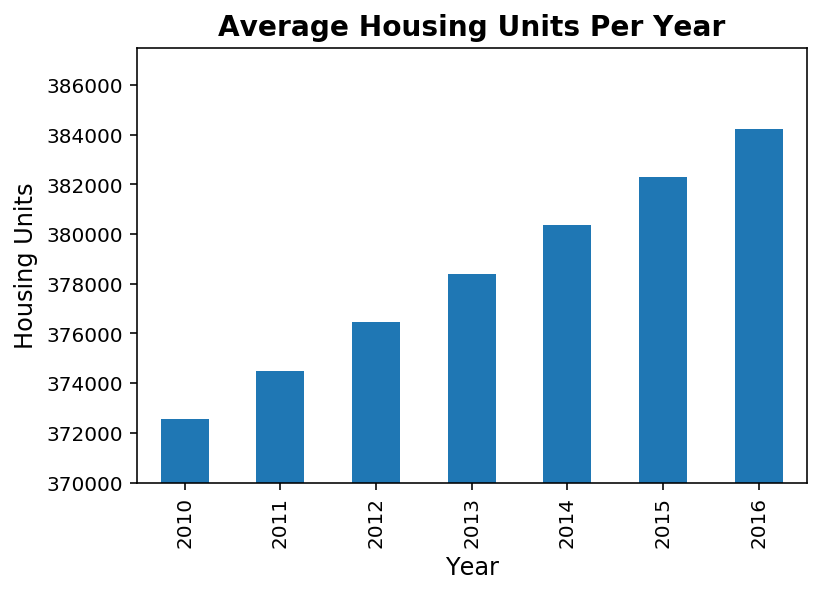
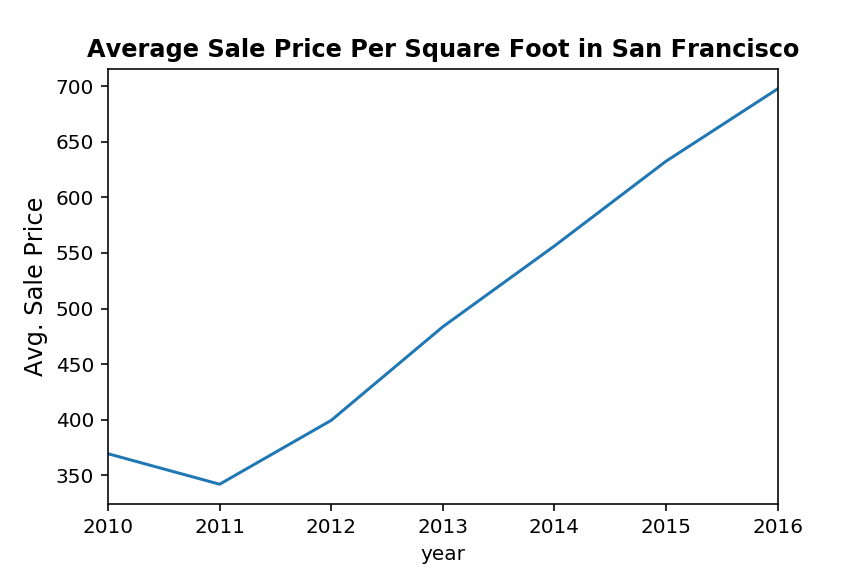
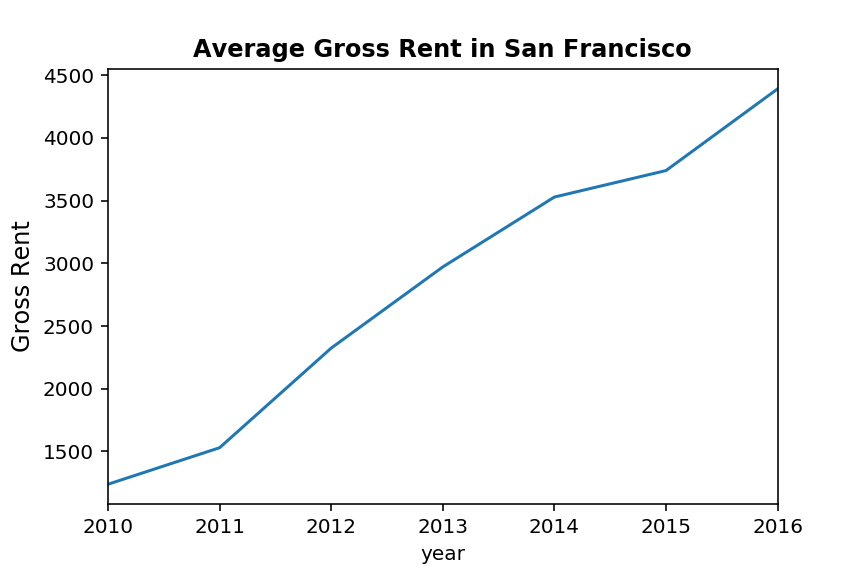

In [86]:
panel_view.servable()